In [18]:
from os.path import join, dirname
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt

# convert netcdfs to geopandas dfs
def nc_to_gdf(ds, return_periods):
    q = ds.sel(return_periods=return_periods)
    df = q.to_dataframe()
    df = df.reset_index()

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.station_x_coordinate, df.station_y_coordinate), crs='epsg:4326')

    return gdf


datadir = join("..", "data")

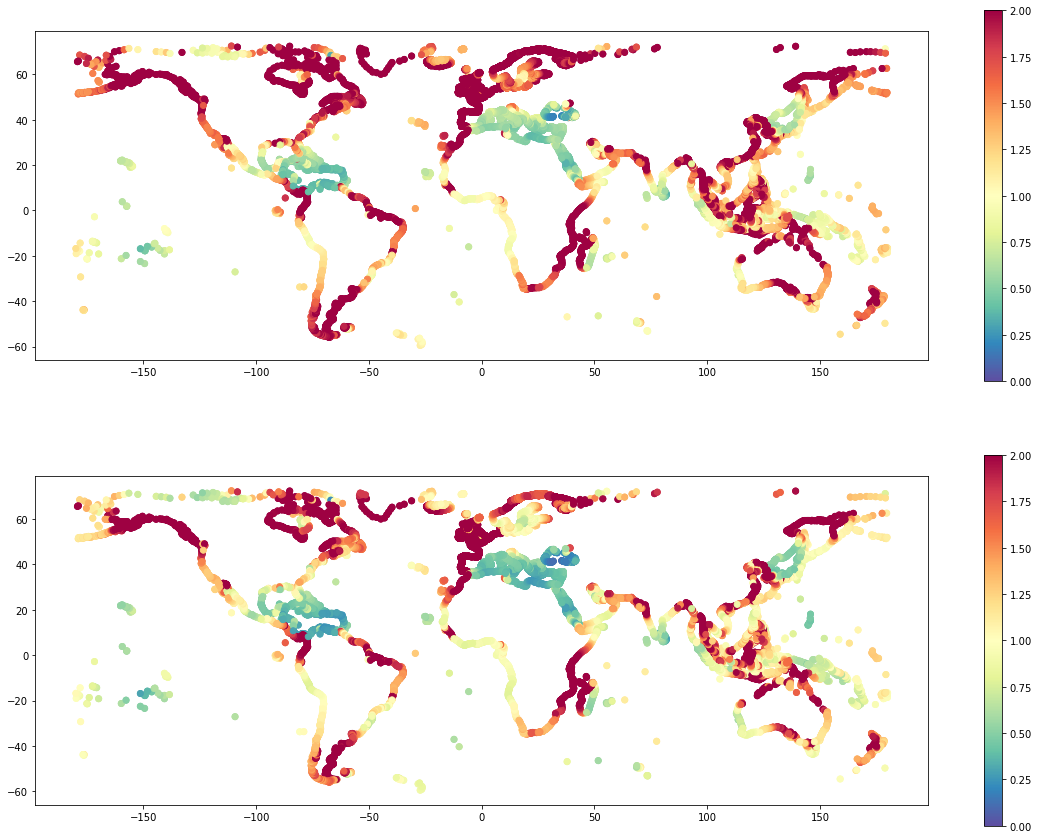

In [37]:
ds = xr.open_dataset(join(datadir, "CODEC_amax_ERA5_1979_2017_coor_mask_GUM_RPS.nc"))

fig, ax = plt.subplots(2, 1, figsize=(20, 15))
gdf_250 = nc_to_gdf(ds, 250.0)
gdf_250.plot('RPS', ax=ax[0], cmap="Spectral_r", vmin=0, vmax=2, legend=True)

gdf_005 = nc_to_gdf(ds, 5.0)
gdf_005.plot('RPS', ax=ax[1], cmap="Spectral_r", vmin=0, vmax=2, legend=True);

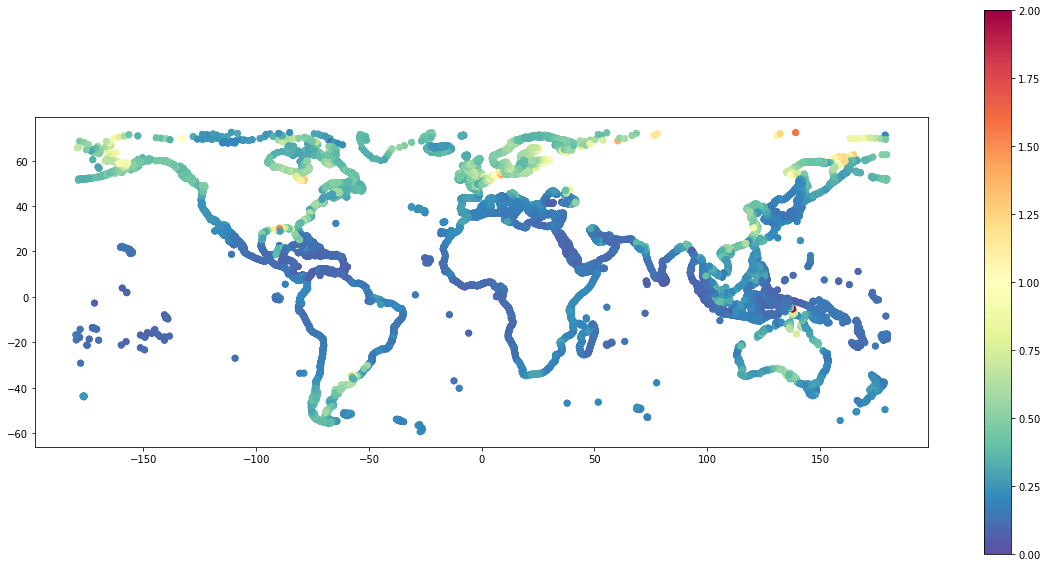

In [49]:
gdf_diff = gdf_005.copy(deep=True)
gdf_diff["diff"] = gdf_250["RPS"] - gdf_005["RPS"]

fig, ax = plt.subplots(figsize=(20, 10))

gdf_diff.plot("diff", ax=ax, cmap="Spectral_r", vmin=0, vmax=2, legend=True);

# Helper code

In [ ]:
### Geopandas GPKG conversion
## Not finished
import xarray as xr

import numpy as np
import geopandas as gpd
import iris
import iris.plot as iplt
from iris.coord_systems import GeogCS
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from mpl_toolkits.axes_grid1 import AxesGrid
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from ascend import Shape as shape  # have to get online
import cartopy.geodesic as cgeo

print("This code isn't finished")
wd = join(dirname(__file__), "..")
quantilesfile = join(wd, "outdata", "fpgrand.T1Hmax.4p4km.nc")
quantiles = [0.5, 0.9, 0.96, 0.98, 0.99] # 1-in-[2, 10, 25, 50, 100]

# load admin boundary files
bgd_file = join(wd, "sup", "bgd_admin", "bgd_admin0.geojson")
bgd = gpd.read_file(bgd_file).unary_union

# define colour map
levels = np.arange(20, 65, 5)
gustcmap = plt.get_cmap('YlOrRd').copy()
gustcmap.set_under('lightgrey', 1.0)
gustcmap.set_over('black', 1.0)
norm = BoundaryNorm(boundaries=levels, ncolors=gustcmap.N)

ds = xr.open_dataset(quantilesfile)

# convert netcdfs to geopandas dfs
def nc_to_gdf(ds, quantile):
    q = ds.sel(quantiles=quantile)
    df = q.to_dataframe()
    df = df.reset_index()

    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="epsg:4326")
    gdf = gdf[['meangust', 'gust_credible_interval', 'geometry']]

    return gdf

q50_gdf = nc_to_gdf(ds, '0.5')
q90_gdf = nc_to_gdf(ds, '0.9')
q95_gdf = nc_to_gdf(ds, '0.95')
q99_gdf = nc_to_gdf(ds, '0.99')
q99p5_gdf = nc_to_gdf(ds, '0.995')

# aggregate into one df
quantile_gdf = q50_gdf[['meangust', "geometry"]]
quantile_gdf['q50'] = q50_gdf['gust_credible_interval']
quantile_gdf['q90'] = q90_gdf['gust_credible_interval']
quantile_gdf['q95'] = q95_gdf['gust_credible_interval']
quantile_gdf['q99'] = q99_gdf['gust_credible_interval']
quantile_gdf['q99p5'] = q99p5_gdf['gust_credible_interval']

# save file
quantile_gdf.to_file(join(wd, "outdata", "wind_quantiles.gpkg"), driver="GPKG")

# plot
quantile_gdf = gpd.clip(quantile_gdf, bgd, keep_geom_type=True)

fig = plt.figure(figsize=(20, 5))
axgr = AxesGrid(fig, 111, axes_class=(GeoAxes, dict(map_projection=ccrs.PlateCarree())),
        nrows_ncols=(1, 5), axes_pad=0.05,
        cbar_location="bottom", cbar_mode="single", cbar_pad=0.2, cbar_size='1%',
        label_mode='')

quantiles = ['q50', 'q90', 'q95', 'q99', 'q99p5']

im = quantile_gdf.plot('q50', ax=axgr[0], cmap=gustcmap, norm=norm)
for i, quantile in enumerate(quantiles):
    quantile_gdf.plot(quantile, ax=axgr[i], cmap=gustcmap, norm=norm)


# Plot place labels
for ax in axgr:# Remove ax frames
    ax.patch.set_visible(False)
    ax.spines['geo'].set_visible(False)
    # Add scale bar
    # scale_bar(ax, (0.42, 0.17), 1_00)

axgr[0].text(0.5, 0.1, "1-in-2 event", ha='center', transform=axgr[0].transAxes, fontsize=10)
axgr[1].text(0.5, 0.1, "1-in-10 event", ha='center', transform=axgr[1].transAxes, fontsize=10)
axgr[2].text(0.5, 0.1, "1-in-20 event", ha='center', transform=axgr[2].transAxes, fontsize=10)
axgr[3].text(0.5, 0.1, "1-in-100 event", ha='center', transform=axgr[3].transAxes, fontsize=10)
axgr[3].text(0.5, 0.1, "1-in-200 event", ha='center', transform=axgr[4].transAxes, fontsize=10)

cbar = fig.colorbar(im.collections[-1], cax=axgr.cbar_axes[0], extend='both', orientation='horizontal')  #
cbar.set_label("Gust Speed (m/s)")

fig.savefig(join(wd, "images", "rp_maps_gpd.png"), bbox_inches="tight")
